In [1]:
%load_ext autoreload
%autoreload 2

# Config

In [2]:
from icehockey_rules.config import get_config

config = get_config()

# Data

## Transcribed Rulebook

### Load Data
(from yaml to a Python dictionary)

In [3]:
from icehockey_rules.rulebook import get_rulebooks, __version__ as parsing_version

rulebooks = get_rulebooks()
iihf_rulebook = rulebooks["iihf"]

### Assert All Ids Unique

In [4]:
ids = []
for rule in iihf_rulebook["rules"]:
    if "situation" in rule:
        for situation in rule["situation"]:
            ids.append(situation["number"])

    for subsection in rule["subsections"]:
        ids.append(subsection["number"])
        
assert len(ids) == len(set(ids))

### Table Form (Pandas)
Example of sections and situations for rule 8

#### Situations

<Axes: >

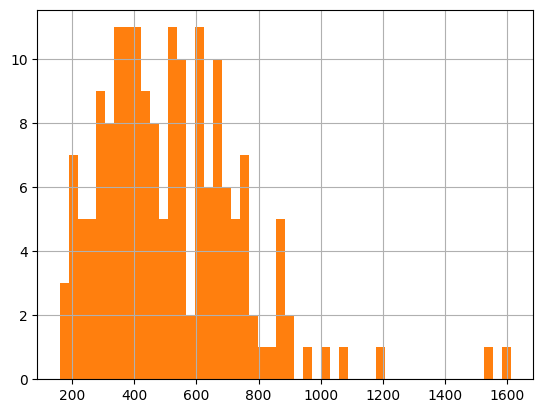

In [5]:
from icehockey_rules.rulebook import get_iihf_situations_df

iihf_situations_df = get_iihf_situations_df()
iihf_situations_df.char_count.hist(bins=50)

#### Subsections

<Axes: >

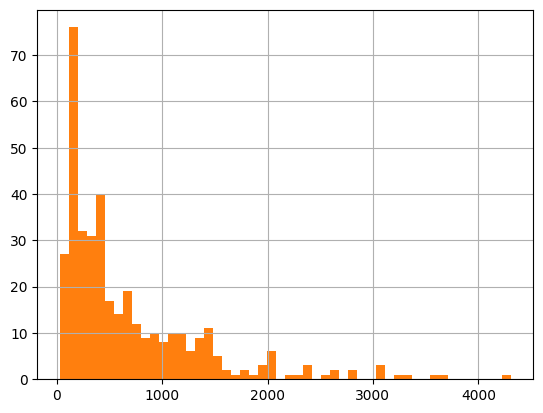

In [6]:
from icehockey_rules.rulebook import get_iihf_subsections_df

iihf_subsections_df = get_iihf_subsections_df()
iihf_subsections_df.char_count.hist(bins=50)

## Rule and Situation Chunks

The plan is to chunk rules by their subsections and casebook situations.  If any one of these chunks is still too big (say more than 300 characters), then further chunk into 300 character segments.

In [7]:
from icehockey_rules.rulebook import get_chunked_iihf_rulebook_records

chunked_iihf_rulebook_records = get_chunked_iihf_rulebook_records(iihf_rulebook)
len(chunked_iihf_rulebook_records)

1126

In [8]:
[record["id"] for record in chunked_iihf_rulebook_records][:10]

['1.1-0',
 '1.1-1',
 '1.2',
 '1.3-0',
 '1.3-1',
 '1.3-2',
 '1.4-0',
 '1.4-1',
 '1.5-0',
 '1.5-1']

## Chunk Embeddings

### Model

In [9]:
from dotenv import load_dotenv
_ = load_dotenv()

In [10]:
from openai import OpenAI

openai_client = OpenAI()

### Embed Rulebook and Persist (or Load)

In [11]:
NAME = f"rulebook--{parsing_version}--{config.embedder.model}"
RE_EMBED = False
NAME

'rulebook--v1--text-embedding-3-small'

In [12]:
from pathlib import Path
import pickle
from copy import deepcopy

chunked_iihf_rulebook_embedding_filepath = Path(f"../data/{NAME}-embeddings.p")

if chunked_iihf_rulebook_embedding_filepath.exists() and not RE_EMBED:
    with chunked_iihf_rulebook_embedding_filepath.open("rb") as f:
        chunked_iihf_rulebook_embeddings = pickle.load(f)

    # Ensure everything besides values are valid
    assert len(chunked_iihf_rulebook_embeddings) == len(chunked_iihf_rulebook_records)
        
else:
    chunked_iihf_rulebook_embeddings = [
        dict(
            id=chunk_record["id"],
            values=embedding_obj.embedding 
        )
        for embedding_obj, chunk_record in zip(
            openai_client.embeddings.create(
                input=[
                    chunk_record["metadata"]["text"]
                    for chunk_record in chunked_iihf_rulebook_records
                ],
                model=config.embedder.model
            ).data,
            chunked_iihf_rulebook_records
        )
    ]

    with chunked_iihf_rulebook_embedding_filepath.open("wb") as f:
        pickle.dump(chunked_iihf_rulebook_embeddings, f)

    with chunked_iihf_rulebook_embedding_filepath.open("rb") as f:
        chunked_iihf_rulebook_embeddings_test = pickle.load(f)
    
    assert chunked_iihf_rulebook_embeddings == chunked_iihf_rulebook_embeddings_test

In [13]:
    with chunked_iihf_rulebook_embedding_filepath.open("wb") as f:
        pickle.dump(chunked_iihf_rulebook_embeddings, f)

In [14]:
embedding_dim = len(chunked_iihf_rulebook_embeddings[0]['values'])
embedding_dim

1536

# Vector Database

## Pinecone

In [15]:
import os
from pinecone.grpc import PineconeGRPC as Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
pinecone_api_key = os.getenv("PINECONE_API_KEY") or "PINECONE_API_KEY"

pinecone_client = Pinecone(api_key=pinecone_api_key)
pinecone_client.list_indexes()

{'indexes': [{'dimension': 1536,
              'host': 'canopy--iihf-rulebook-7748f17.svc.gcp-starter.pinecone.io',
              'metric': 'cosine',
              'name': 'canopy--iihf-rulebook',
              'spec': {'pod': {'environment': 'gcp-starter',
                               'pod_type': 'starter',
                               'pods': 1,
                               'replicas': 1,
                               'shards': 1}},
              'status': {'ready': True, 'state': 'Ready'}},
             {'dimension': 1536,
              'host': 'rulebook--v1--text-embedding-3-small-7748f17.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'rulebook--v1--text-embedding-3-small',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}

### Create Index

In [16]:
from pinecone import ServerlessSpec
from icehockey_rules.retrieve import INDEX_NAME, PINECONE_INDEX


if INDEX_NAME not in [index["name"] for index in pinecone_client.list_indexes()]:
    pinecone_client.create_index(
        name=INDEX_NAME,
        dimension=embedding_dim,
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws', 
            region='us-east-1'
        ) 
    )

### Populate Index

In [17]:
def chunker(seq, batch_size):
  return (seq[pos:pos + batch_size] for pos in range(0, len(seq), batch_size))

yn_sure = input("are you sure you want to index?")
if yn_sure.lower() == 'y':
    print("indexing")
    async_results = [
        PINECONE_INDEX.upsert(vectors=chunk, async_req=True)
        for chunk in chunker(chunked_iihf_rulebook_embeddings, batch_size=100)
    ]
    
    # Wait for and retrieve responses (in case of error)
    [async_result.result() for async_result in async_results]

del chunked_iihf_rulebook_embeddings

are you sure you want to index? n


In [19]:
assert PINECONE_INDEX.describe_index_stats()["total_vector_count"] == len(chunked_iihf_rulebook_records)

# Retrieval

## In Memory Rule Index

In [20]:
from icehockey_rules.rulebook import get_inmem_chunked_iihf_rulebook_index

inmem_chunked_iihf_rulebook_index = get_inmem_chunked_iihf_rulebook_index()
assert len(inmem_chunked_iihf_rulebook_index) == len(chunked_iihf_rulebook_records)

## Query

In [21]:
SITUATION = "Can a player win a faceoff with their glove?"
TOP_K_CHUNKS = config.retriever.top_k_chunks

## Retreive Rule Matches and Retrieval Scores

In [31]:
from icehockey_rules.retrieve import retrieve, chunk_matches_to_rules_df

chunk_matches = retrieve(query=SITUATION, top_k=TOP_K_CHUNKS).matches
rule_matches_df = chunk_matches_to_rules_df(chunk_matches)
rule_matches_df

score                                 title
                  sum count                                
rule_number                                                
67           1.115870     2                   HANDLING PUCK
9            1.090936     2                        UNIFORMS
69           0.536357     1  INTERFERENCE ON THE GOALKEEPER
27           0.535971     1          GOALKEEPER'S PENALTIES
72           0.535301     1       REFUSING TO PLAY THE PUCK
63           0.530113     1               DELAYING THE GAME

# RAG

## Prompts

In [33]:
from icehockey_rules.chat import query_to_rag_prompt, SYSTEM_PROMPT

system_prompt = SYSTEM_PROMPT
rag_prompt = query_to_rag_prompt(query=SITUATION)
len(system_prompt) + len(rag_prompt)

54763

## Ask ChatGPT

In [34]:
print(rag_prompt)


CONTEXT:
    
    RULE 67. HANDLING PUCK:
    
        67.1. HANDLING PUCK:
        This rule outlines fouls that can result in a penalty when a Player illegally uses their hand on the puck. ➔ Rule 79 – Hand Pass for all references related to passing the puck with the hand.

        67.2. HANDLING PUCK - MINOR PENALTY – SKATER:
        A Player shall be permitted to catch the puck out of the air but must immediately place it or knock it down to the ice.
A Player shall be assessed a Minor Penalty for "closing their hand on the puck": (I) If they catch it and skates with it, either to avoid a check or to gain a "territorial advantage" over their opponent. (II) If they place their hand over the puck while it is on the ice in order to conceal it from or prevent an opponent from playing the puck. When this is done in their Team's Goal Crease area, a "Penalty Shot" shall be assessed Rule 67.4 – Penalty Shot, or Rule 67.5 – Goal Awarded. (III) If they pick the puck up off the ice with their 

In [27]:
system_prompt = """You are an ice hockey rule assistant. 
Given a question or situation, describe what the rules indicate should happen using only the context provided.
Always source the associated rule number and title in the context.
If you cannot answer based on the context, respond with "I couldn't come up with an answer, but here are
some potentially relevant rules:" followed by a list the RULE numbers and titles found in the context.
"""

completion = openai_client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
    dict(role="system", content=system_prompt),
    dict(role="user", content=rag_prompt),
    ],
    temperature=0.0
)


In [28]:
print("Question:", SITUATION)
print("Answer:\n", completion.choices[0].message.content)
print("Rules Retrieved:", rule_matches_df)

Question: Can a player win a faceoff with their glove?
Answer:
 I couldn't come up with an answer, but here are some potentially relevant rules:

- [RULE 67: ILLEGAL SUBSTITUTION]
- [RULE 9: UNIFORMS]
- [RULE 69: INTERFERENCE ON THE GOALKEEPER]
- [RULE 27: GOALKEEPER'S PENALTIES]
- [RULE 72: REFUSING TO PLAY THE PUCK]
- [RULE 63: DELAYING THE GAME]
- [RULE 24: PENALTY SHOT]
- [RULE 8: INJURED PLAYERS]
Rules Retrieved:                 score                                 title
                  sum count                                
rule_number                                                
67           1.115870     2            ILLEGAL SUBSTITUTION
9            1.090936     2                        UNIFORMS
69           0.536357     1  INTERFERENCE ON THE GOALKEEPER
27           0.535971     1          GOALKEEPER'S PENALTIES
72           0.535301     1       REFUSING TO PLAY THE PUCK
63           0.530113     1               DELAYING THE GAME
24           0.529196     1           

# As PIPELINE

In [74]:
from icehockey_rules.pipelines import one_off_question_answer

print("Question:", SITUATION)
one_off_question_answer(query=SITUATION, model="gpt-4o-2024-05-13")

Question: Two players punch each other after the game is over.


ChatCompletionMessage(content='According to Rule 46.9, "Fighting Other Than During the Periods of the Game," any players involved in an altercation after the game has ended will be investigated by the proper authorities, and supplementary discipline can be applied in addition to any other appropriate penalties. Players involved in fighting after the game shall be assessed a Major Penalty ("Fighting") and an automatic Game Misconduct Penalty (5\'+GMP). If one of the players is deemed to be an "Aggressor" or an "Instigator/Initiator," they will be penalized according to Rule 46.3 and/or Rule 46.4.\n\n**Source:** Rule 46.9 – Fighting Other Than During the Periods of the Game', role='assistant', function_call=None, tool_calls=None)

# From API

In [69]:
import requests

endpoint_url = "http://localhost:8000/context/chat/completions"

access_token = os.getenv("API_KEY")

response = requests.post(url=endpoint_url, params=dict(query="hello"), headers=dict(access_token=access_token))
response.status_code

403